## Auto Claims Prediction
This project is intended to help auto insurers predict the likelihood of a policyholder filing a claim within the policy period.<br><br>
The data set originates from an unnamed auto insurer who provided nearly 60,000 policyholder records. Each record identifies whether the policyholder incurred an accident during that policy period. The data set is believed to contain claims data for US policyholders as one of the data attributes provides a safety rating issued by the National Highway Traffic Safety Administration (NHTSA), which is a US federal agency.
<br><br>
The data set includes anonymized information about the policy holder (driver), location of the car, and details on the car covered by the policy. In total, there are 80+ potential fields for model building covering the key risk properties of an auto policy.


Data Source: https://www.kaggle.com/datasets/ifteshanajnin/carinsuranceclaimprediction-classification<br>
Target Field: is_claim

In [1]:
# Load libraries

import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data set

FILE = 'train_claims.csv'
policy_df = pd.read_csv(FILE)

In [3]:
# Shape of data

policy_df.shape

(58592, 44)

### Exploratory Data Analysis

In [4]:
# Provide a list of features and field type.

policy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

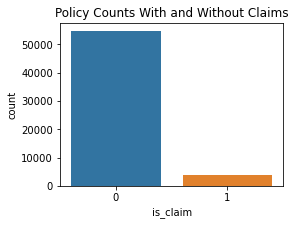

In [5]:
# Most policyholders do not have a claim. We will need to rebalance the data set to balance our target variable.

plt.figure(figsize=(4, 3))
sns.countplot(data=policy_df, x='is_claim')
plt.title('Policy Counts With and Without Claims')
plt.show()

In [6]:
# Group variables by field type.

cat_cols = policy_df.select_dtypes(include='object')
num_cols= policy_df.select_dtypes(include =['float64','int64'])

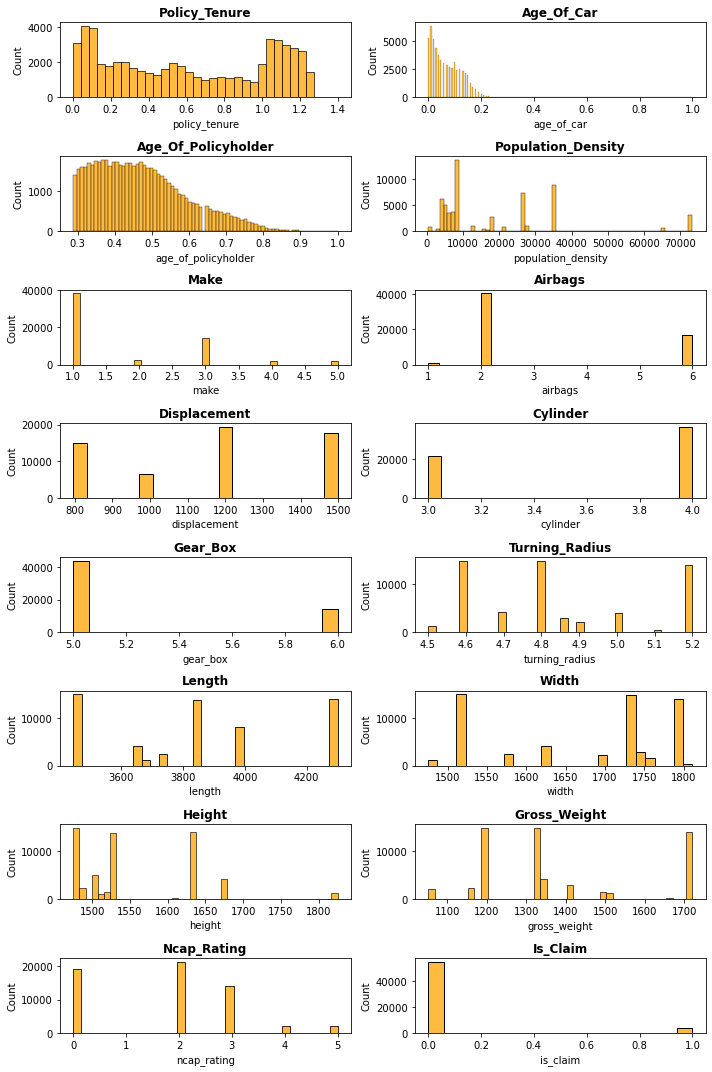

In [7]:
# Review data charts of categorical variables.

plt.figure(figsize=(10,15))
for n, col in enumerate(num_cols.columns):
    plot=plt.subplot(8,2,n+1)
    sns.histplot(data=policy_df, x=col, color='orange')
    plt.title(f'{col.title()}',weight='bold')
    plt.tight_layout()

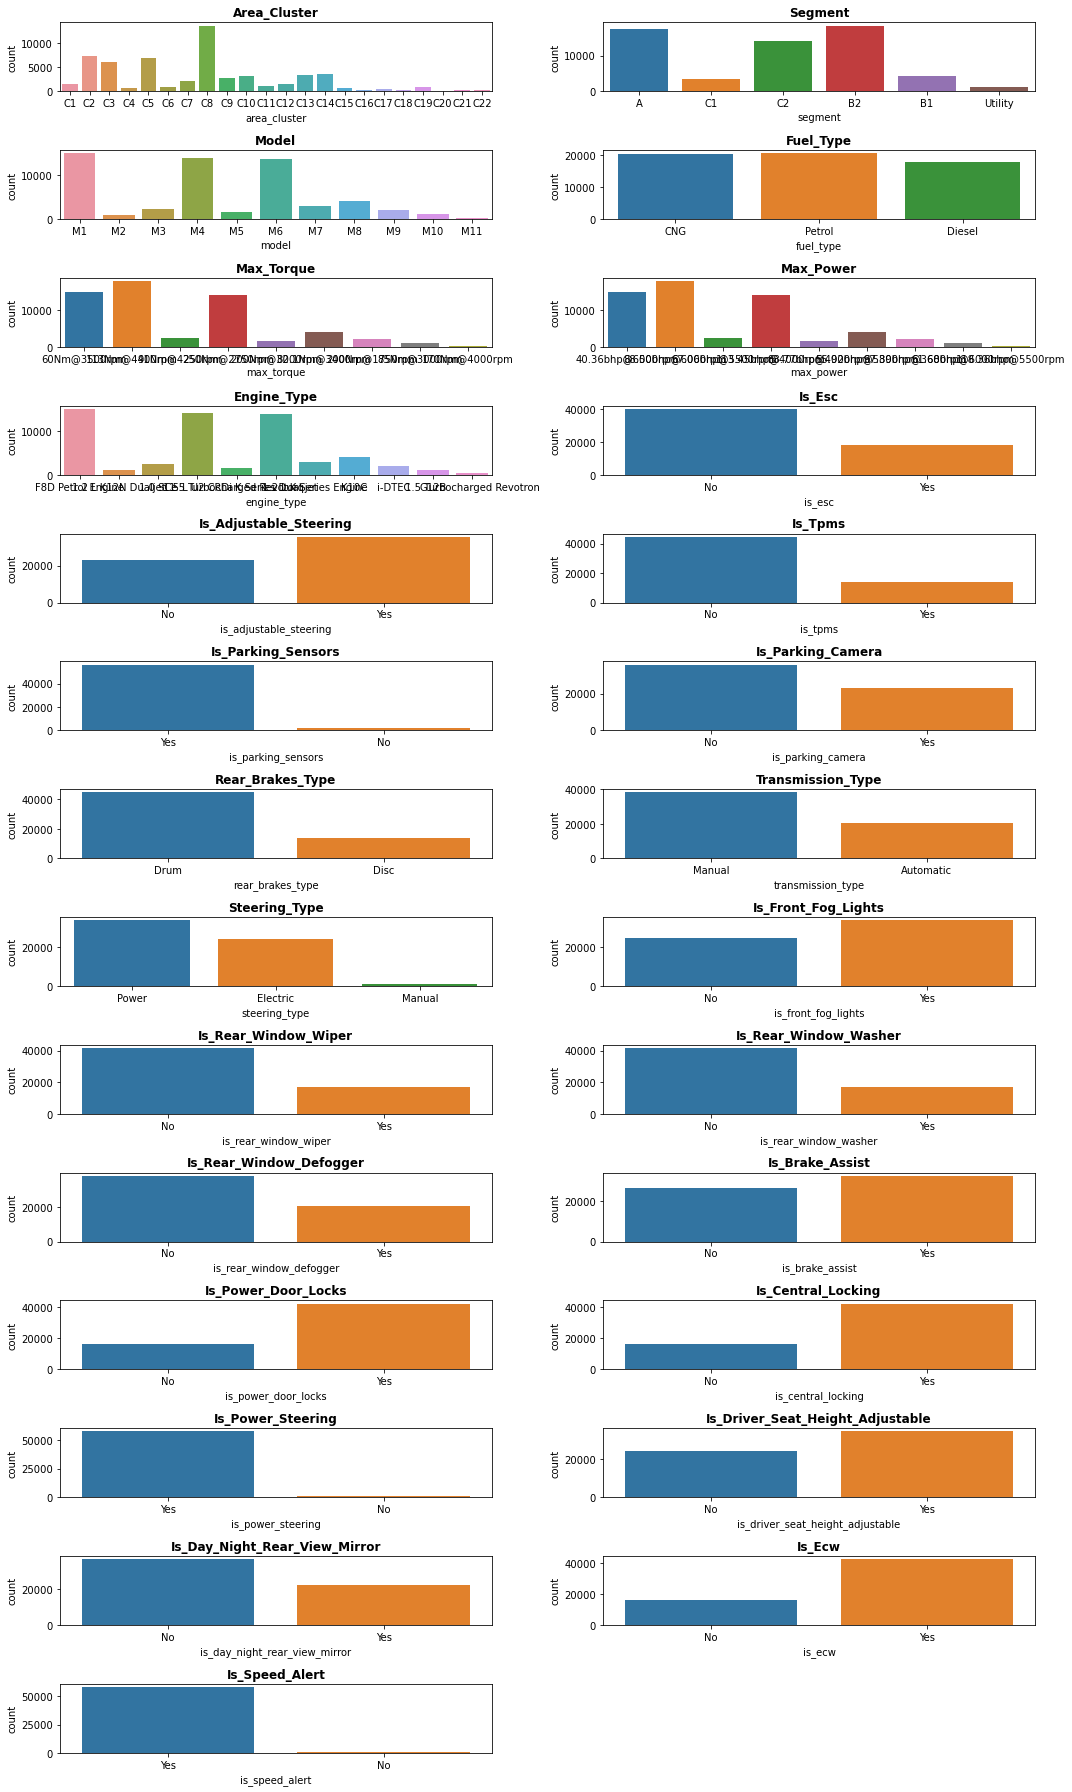

In [8]:
# Review data charts of categorical variables. Exclude policy_id as it is not a modeling variable.

attributes = ['area_cluster', 'segment', 'model', 'fuel_type',
       'max_torque', 'max_power', 'engine_type', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'transmission_type',
       'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert']

plt.figure(figsize=(15, 25))
for n, col in enumerate(attributes):
    plot=plt.subplot(14,2,n+1)
    sns.countplot(data=policy_df, x=col)
    plt.title(f'{col.title()}',weight='bold')
    plt.tight_layout()

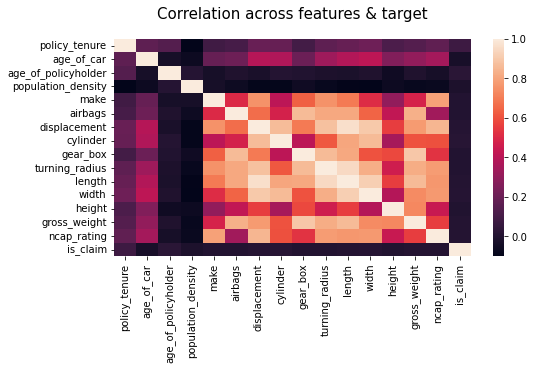

In [9]:
# Review relationship of features.
# There are several features with correlations in the high 80's and 90's that may need to be removed in our model.
    # Ex: length and turning radius are correlated, which makes sense. Turning radius may be more relevant for accident assessment.
    

corr_matrix = policy_df.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix)
plt.title('Correlation across features & target', size=15, pad=20)
plt.show()

In [10]:
policy_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


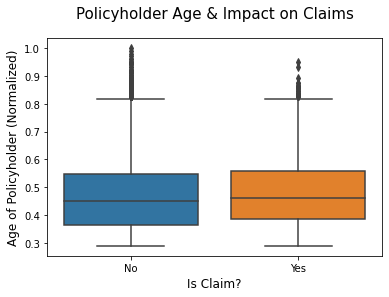

In [11]:
# Show distributions for Age of Policyholder.

sns.boxplot(data=policy_df, x='is_claim', y='age_of_policyholder')
plt.title('Policyholder Age & Impact on Claims', size=15, pad=20)
plt.ylabel('Age of Policyholder (Normalized)', size=12)
plt.xlabel('Is Claim?', size=12)
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

### Pipeline Processing

- Drop unnecessary columns - 'policy_id'
- Convert max_power and max_torque to numerical values.
- One-hot encode remaining categorical variables.

In [12]:
# Drop Identifier fields

pipeline_df = policy_df.drop('policy_id', axis=1)

In [13]:
# Convert max power to numeric.

power = []
for x, y in pipeline_df['max_power'].str.split('bhp'):
    power.append(x)

pipeline_df['max_power_bhp'] = power
pipeline_df['max_power_bhp'] = pipeline_df['max_power_bhp'].astype('float64')

pipeline_df = pipeline_df.drop('max_power', axis=1)

In [14]:
# Convert max torque to numeric.

torque = []
for x, y in pipeline_df['max_torque'].str.split('Nm@'):
    torque.append(x)

pipeline_df['max_torque_Nm'] = torque
pipeline_df['max_torque_Nm'] = pipeline_df['max_torque_Nm'].astype('float64')

pipeline_df = pipeline_df.drop('max_torque', axis=1)

In [15]:
# Convert categorical to dummy variables.

pipeline_df = pd.get_dummies(data=pipeline_df, drop_first=True)

In [16]:
# Test outputs of one-hot encoding.

policy_df.shape, pipeline_df.shape

((58592, 44), (58592, 87))

### Model Building

- The data is already standardized. No scaling needs to be performed.
- Class imbalances need to be addressed in the training set. SMOTE will be used to address the imbalance.
- Several variables are categorical and require one-hot encoding.

In [17]:
# Split pipeline into train/test set.

features = pipeline_df.drop('is_claim', axis=1)
target = pipeline_df['is_claim']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [18]:
# Adjust training set for target variable imbalance.

sm = SMOTE(sampling_strategy=1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [19]:
# Test sample rebalancing

print(f'Size of test set: {x_train.shape}')
print(f'Size of resampled set: {x_train_res.shape}')

y_train_res.groupby(y_train_res).count()

Size of test set: (46873, 86)
Size of resampled set: (87884, 86)


is_claim
0    43942
1    43942
Name: is_claim, dtype: int64

In [20]:
# Run a Random Forest model using gridsearch to pick the best parameters.

rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [700, 800, 1000],
    'max_depth' : [12, 15, 18, 20],
    'max_features' : ['log2', 'sqrt'],
    'criterion' :['gini']
}

rfc_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
rfc_grid.fit(x_train_res, y_train_res)

rfc_grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 800}

In [21]:
# Run confusion matrix and F1 score.

y_pred = rfc_grid.predict(x_test)

print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.17031373582915896
Accuracy Score: 0.7314617288164519
[[8249 2653]
 [ 494  323]]


In [22]:
# Create classification report.

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     10902
           1       0.11      0.40      0.17       817

    accuracy                           0.73     11719
   macro avg       0.53      0.58      0.51     11719
weighted avg       0.89      0.73      0.79     11719



In [23]:
# Run an XGBoost Model

xgb = XGBClassifier(objective='binary:logistic')

param_grid1 = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5]
}
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid1, cv=3, scoring='roc_auc')
xgb_grid.fit(x_train_res, y_train_res)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.5], 'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 7], 'reg_lambda': [0, 1, 10],
                         'scale_pos_weight': [1, 3, 5], 'subsample': [0.8]},
             scoring='roc_auc')

In [24]:
# Run confusion matrix and F1 score.
y_pred1 = xgb_grid.predict(x_test)

print(f'F1 Score: {f1_score(y_test, y_pred1)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred1)}')
print(confusion_matrix(y_test, y_pred1))

F1 Score: 0.16885420361830436
Accuracy Score: 0.8000682652103421
[[9138 1764]
 [ 579  238]]


In [25]:
# Create classification report.

print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     10902
           1       0.12      0.29      0.17       817

    accuracy                           0.80     11719
   macro avg       0.53      0.56      0.53     11719
weighted avg       0.88      0.80      0.84     11719

